In [1]:
#pulling in packages...


import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import *
from scipy import sparse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt

/Users/nathanielschub/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nathanielschub/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# pulling in data, fixing genre column
mb_df = pd.read_csv("movies_metadata.csv", error_bad_lines=False)
mb_df.genre=mb_df.genre.str.replace('[^a-zA-Z]', '')

#removing budget or revenue zeros
mb_df=mb_df[mb_df.budget >0]
mb_df=mb_df[mb_df.revenue >0]
mb_df=mb_df.dropna()

#removing weird id values
mb_df=mb_df[mb_df.genre !='VALUE']
mb_df=mb_df[mb_df.genre !='ediaid']
mb_df=mb_df[mb_df.genre !='id']
mb_df=mb_df[mb_df.genre !='Productionsid']

#add release month
mb_df['release_date']=mb_df['release_date'].astype(str)
mb_df['release_month']=mb_df['release_date'].map(lambda x: x[5:7])

#add YR-MTH to connect to inflation table
mb_df['YR-MTH']=mb_df['release_date'].map(lambda x: x[:7])

print mb_df.shape
print mb_df.head()

/Users/nathanielschub/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5941, 21)
   adult  Franchise    budget      genre     id    imdb_id original_language  \
1  FALSE          0  65000000  Adventure   8844  tt0113497                en   
3  FALSE          0  16000000     Comedy  31357  tt0114885                en   
4  FALSE          1         0     Comedy  11862  tt0113041                en   
5  FALSE          0  60000000     Action    949  tt0113277                en   
8  FALSE          0  35000000     Action   9091  tt0114576                en   

                original_title  \
1                      Jumanji   
3            Waiting to Exhale   
4  Father of the Bride Part II   
5                         Heat   
8                 Sudden Death   

                                            overview popularity   ...     \
1  When siblings Judy and Peter discover an encha...    17.0155   ...      
3  Cheated on, mistreated and stepped on, the wom...    3.85949   ...      
4  Just when George Banks has recovered from his ...    8.38752   ...      

In [3]:
print np.unique(mb_df.genre)

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'ScienceFiction' 'TVMovie' 'Thriller' 'War' 'Western']


In [4]:
#pulling in inflation, adding YR-MTH column to link to movies df

inflation=pd.read_csv("https://www.quandl.com/api/v3/datasets/RATEINF/CPI_USA.csv?api_key=EaN-sDKDUb9c3AXGdQkS")
inflation['YR-MTH']=inflation['Date'].map(lambda x: x[:7])
print inflation.head()
print inflation.tail()

         Date    Value   YR-MTH
0  2017-10-31  246.663  2017-10
1  2017-09-30  246.819  2017-09
2  2017-08-31  245.519  2017-08
3  2017-07-31  244.786  2017-07
4  2017-06-30  244.955  2017-06
            Date  Value   YR-MTH
1253  1913-05-31    9.7  1913-05
1254  1913-04-30    9.8  1913-04
1255  1913-03-31    9.8  1913-03
1256  1913-02-28    9.8  1913-02
1257  1913-01-31    9.8  1913-01


In [5]:
#join inflation and movie dfs
mb_df=pd.merge(mb_df, inflation, on ='YR-MTH', how ='left')
print mb_df.head()

print np.unique(mb_df['YR-MTH'])

   adult  Franchise    budget      genre     id    imdb_id original_language  \
0  FALSE          0  65000000  Adventure   8844  tt0113497                en   
1  FALSE          0  16000000     Comedy  31357  tt0114885                en   
2  FALSE          1         0     Comedy  11862  tt0113041                en   
3  FALSE          0  60000000     Action    949  tt0113277                en   
4  FALSE          0  35000000     Action   9091  tt0114576                en   

                original_title  \
0                      Jumanji   
1            Waiting to Exhale   
2  Father of the Bride Part II   
3                         Heat   
4                 Sudden Death   

                                            overview popularity  ...    \
0  When siblings Judy and Peter discover an encha...    17.0155  ...     
1  Cheated on, mistreated and stepped on, the wom...    3.85949  ...     
2  Just when George Banks has recovered from his ...    8.38752  ...     
3  Obsessive maste

In [6]:
#finding cpi

mb_df['CPI']=mb_df['Value'].map(lambda x: 246.663/float(x))

#calcing adjusted revenue and budget
mb_df.budget=mb_df.budget.astype(float)
mb_df.revenue=mb_df.revenue.astype(float)

mb_df['budget_adj']=mb_df.budget*mb_df.CPI
mb_df['revenue_adj']=mb_df.revenue*mb_df.CPI


#defining is_blockbuster
mb_df['is_blockbuster']= np.where(mb_df.revenue_adj-mb_df.budget_adj>100000000,1,0)

mb_df=mb_df[mb_df['budget']>0]
mb_df=mb_df[mb_df['revenue']>0]

print mb_df.head()
print mb_df.shape
print mb_df['is_blockbuster'].sum()

   adult  Franchise      budget      genre     id    imdb_id  \
0  FALSE          0  65000000.0  Adventure   8844  tt0113497   
1  FALSE          0  16000000.0     Comedy  31357  tt0114885   
3  FALSE          0  60000000.0     Action    949  tt0113277   
4  FALSE          0  35000000.0     Action   9091  tt0114576   
5  FALSE          1  58000000.0  Adventure    710  tt0113189   

  original_language     original_title  \
0                en            Jumanji   
1                en  Waiting to Exhale   
3                en               Heat   
4                en       Sudden Death   
5                en          GoldenEye   

                                            overview popularity  \
0  When siblings Judy and Peter discover an encha...    17.0155   
1  Cheated on, mistreated and stepped on, the wom...    3.85949   
3  Obsessive master thief, Neil McCauley leads a ...    17.9249   
4  International action superstar Jean Claude Van...    5.23158   
5  James Bond must unmask t

In [7]:
#defining titles
titles=mb_df.title.values


print titles[0:5]
print titles.shape

['Jumanji' 'Waiting to Exhale' 'Heat' 'Sudden Death' 'GoldenEye']
(4625,)


In [8]:
#filtering out non-alpha characters from titles
for i in range(len(titles)):        
        titles[i]=re.sub("[^a-zA-Z]+", " ", titles[i])
        titles[i]=titles[i].lower()
        titles[i]=re.sub(r'\b\w{1,3}\b', ' ', titles[i])

In [9]:
#running count_vectorizer on titles
cv=CountVectorizer(min_df=10)
title_cv=cv.fit_transform(titles)
print title_cv.shape

test_features=cv.get_feature_names()
print test_features


(4625, 89)
[u'about', u'after', u'american', u'baby', u'back', u'battle', u'before', u'best', u'black', u'blood', u'blue', u'boys', u'christmas', u'city', u'dark', u'dawn', u'days', u'dead', u'death', u'devil', u'down', u'dragon', u'earth', u'escape', u'evil', u'final', u'fire', u'four', u'friday', u'from', u'game', u'ghost', u'girl', u'good', u'great', u'halloween', u'hard', u'harry', u'heart', u'heaven', u'high', u'home', u'hood', u'house', u'kill', u'king', u'land', u'last', u'legend', u'life', u'like', u'little', u'lost', u'love', u'meet', u'monster', u'movie', u'never', u'next', u'night', u'paris', u'part', u'perfect', u'planet', u'prince', u'return', u'road', u'rock', u'secret', u'space', u'star', u'story', u'street', u'this', u'time', u'train', u'trek', u'walk', u'water', u'wedding', u'what', u'when', u'white', u'wild', u'with', u'woman', u'world', u'year', u'your']


In [10]:
#defining new df, adding dummies, combining with titles

mx=mb_df[['is_blockbuster','adult', 'Franchise', 'budget_adj', 'genre','runtime', 'release_month']]

mx = mx.join(pd.get_dummies(mx['genre'])).drop('genre', axis=1)
mx = mx.join(pd.get_dummies(mx['adult'])).drop('adult', axis=1)
mx = mx.join(pd.get_dummies(mx['release_month'])).drop('release_month', axis=1)

print mx.head()

movie_array=sparse.hstack((mx,title_cv))

print movie_array.shape

   is_blockbuster  Franchise    budget_adj  runtime  Action  Adventure  \
0               1          0  1.044501e+08    104.0     0.0        1.0   
1               1          0  2.571080e+07    127.0     0.0        0.0   
3               1          0  9.641550e+07    170.0     1.0        0.0   
4               0          0  5.624238e+07    106.0     1.0        0.0   
5               1          1  9.314098e+07    130.0     0.0        1.0   

   Animation  Comedy  Crime  Documentary ...    03   04   05   06   07   08  \
0        0.0     0.0    0.0          0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0     1.0    0.0          0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0     0.0    0.0          0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0     0.0    0.0          0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
5        0.0     0.0    0.0          0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   

    09   10   11   12  
0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  1.0  
3  0.0  

In [11]:
#slicing train and test data sets
movie_array=movie_array.toarray()

train_data=movie_array[0:3500,1:]
train_labels=movie_array[0:3500,0] #.reshape(len(train_labels,1))

test_data=movie_array[3500:,1:]
test_labels=movie_array[3500:,1] #.reshape(len(test_labels, 1))

print train_data.shape
print train_labels.shape

print test_data.shape
print test_labels.shape


(3500, 125)
(3500,)
(1125, 125)
(1125,)


for k =  5, accuracy =0.771556
for k = 15, accuracy =0.796444
for k = 25, accuracy =0.800000
for k = 35, accuracy =0.809778
for k = 45, accuracy =0.808889
for k = 55, accuracy =0.808889
for k = 65, accuracy =0.806222
for k = 75, accuracy =0.806222
for k = 85, accuracy =0.807111
for k = 95, accuracy =0.804444


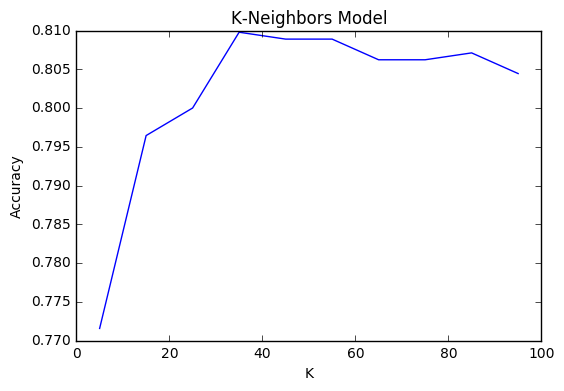

139.0


In [86]:
#knn model

k_values = range(5,100,10)
acc=[]
kvals=[]
for k in k_values:
    clf=KNeighborsClassifier(k)
    clf.fit(train_data, train_labels)
    preds_knn=clf.predict(test_data)
    accuracy=metrics.accuracy_score(test_labels, preds_knn)
    
    acc.append(accuracy)
    kvals.append(k)
    print 'for k =%3d, accuracy =%3f' %(k,accuracy)
    
plt.plot(kvals,acc)
plt.title('K-Neighbors Model')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()
print sum(preds_knn)

286.0
for alpha =0.000000, accuracy score =0.769778
286.0
for alpha =0.000100, accuracy score =0.769778
286.0
for alpha =0.001000, accuracy score =0.769778
286.0
for alpha =0.010000, accuracy score =0.769778
286.0
for alpha =0.100000, accuracy score =0.769778
286.0
for alpha =0.500000, accuracy score =0.769778
286.0
for alpha =1.000000, accuracy score =0.769778
286.0
for alpha =2.000000, accuracy score =0.769778
287.0
for alpha =10.000000, accuracy score =0.768889


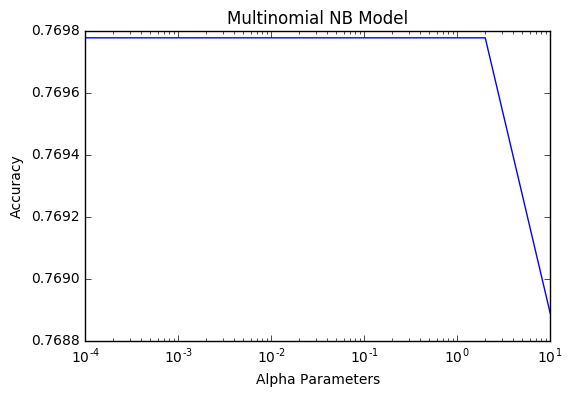

In [85]:
#nb model

alphas = {'alpha': [0., 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
alpha_list=alphas['alpha']

acc=[]
alphavals=[]
for alpha in alpha_list:
    mnb=MultinomialNB(alpha=alpha)
    mnb.fit(train_data, train_labels)
    preds_mnb=mnb.predict(test_data)
    accuracy=metrics.accuracy_score(test_labels, preds_mnb)
    print sum(preds_mnb)
    acc.append(accuracy)
    alphavals.append(alpha)
    print 'for alpha =%3f, accuracy score =%3f' %(alpha,accuracy)
    
plt.semilogx(alphavals, acc)
plt.title('Multinomial NB Model')
plt.xlabel('Alpha Parameters')
plt.ylabel('Accuracy')
plt.show()

for C =0.001000, accuracy=0.809778, sum of squared weights=0.000232,
for C =0.010000, accuracy=0.828444, sum of squared weights=0.078647,
for C =0.100000, accuracy=0.864000, sum of squared weights=3.530815,
for C =1.000000, accuracy=0.885333, sum of squared weights=23.926882,
for C =10.000000, accuracy=0.882667, sum of squared weights=97.060142,
for C =100.000000, accuracy=0.880000, sum of squared weights=240.830039,
for C =1000.000000, accuracy=0.878222, sum of squared weights=391.053167,


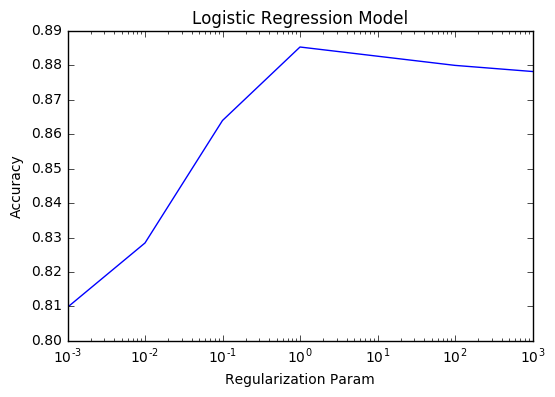

In [22]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
C_list=param_grid['C']

cvals=[]
acc=[]

for C in C_list:
    lr=LogisticRegression(penalty='l1',C=C)
    lr.fit(train_data, train_labels)
    preds_lr=lr.predict(test_data)
    accuracy=metrics.accuracy_score(test_labels, preds_lr)
    s_sq_weights=np.sum(np.square(lr.coef_))

    cvals.append(C)
    acc.append(accuracy)
    print 'for C =%3f, accuracy=%3f, sum of squared weights=%3f,' %(C, accuracy,s_sq_weights)

plt.semilogx(cvals, acc) 
plt.xlabel('Regularization Param')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Model')
plt.show()

In [42]:
#lr with best params, c=1.
lr1=LogisticRegression(penalty='l1',C=1.)
lr1.fit(train_data, train_labels)

print lr1.coef_.T.shape
coefs=lr1.coef_.T




(125, 1)


In [43]:
col_names=list(mx)
col_names=np.array(col_names[1:]+test_features).reshape(125,1)
stack=np.hstack((col_names, coefs))
print stack

ValueError: cannot reshape array of size 96 into shape (125,1)

In [17]:
stack[stack[:,1].argsort()]


array([[u'Fantasy', u'-0.00418292039278'],
       [u'story', u'-0.00931031162907'],
       [u'friday', u'-0.0380870618072'],
       [u'little', u'-0.0524851549185'],
       [u'02', u'-0.0561989587698'],
       [u'Drama', u'-0.0990424934777'],
       [u'ScienceFiction', u'-0.100577207453'],
       [u'10', u'-0.10558743907'],
       [u'night', u'-0.12205093739'],
       [u'street', u'-0.123051365032'],
       [u'heart', u'-0.156989870811'],
       [u'Western', u'-0.196785658894'],
       [u'water', u'-0.218848760334'],
       [u'halloween', u'-0.227218239477'],
       [u'christmas', u'-0.229047766914'],
       [u'your', u'-0.229117310083'],
       [u'08', u'-0.2336105163'],
       [u'dead', u'-0.281292834875'],
       [u'return', u'-0.287541093075'],
       [u'09', u'-0.325605602493'],
       [u'death', u'-0.346711506818'],
       [u'03', u'-0.362726006107'],
       [u'Action', u'-0.367460655877'],
       [u'Horror', u'-0.371909753977'],
       [u'space', u'-0.382798084625'],
       [u'0

In [64]:
mo=mb_df[['original_title','is_blockbuster','adult', 'Franchise', 'budget_adj', 'genre','runtime', 'release_month']]
#print mo.head()

print mo.reindex()


                                       original_title  is_blockbuster  adult  \
0                                             Jumanji               1  FALSE   
1                                   Waiting to Exhale               1  FALSE   
3                                                Heat               1  FALSE   
4                                        Sudden Death               0  FALSE   
5                                           GoldenEye               1  FALSE   
6                              The American President               0  FALSE   
8                                               Nixon               0  FALSE   
9                                    Cutthroat Island               0  FALSE   
10                                             Casino               1  FALSE   
11                              Sense and Sensibility               1  FALSE   
12                                         Four Rooms               0  FALSE   
13                     Ace Ventura: When

In [79]:
probs=lr1.predict_proba(train_data)
log_probs=lr1.predict_log_proba(train_data)
preds=lr1.predict(test_data)
print sum(preds)
print sum(test_labels)


print probs[0]
print log_probs[0]

182.0
231.0
[ 0.59593585  0.40406415]
[-0.51762225 -0.90618163]


In [68]:
print mx.head(1)

     title  is_blockbuster  adult  Franchise    budget_adj      genre  \
0  jumanji               1  FALSE          0  1.044501e+08  Adventure   

   runtime release_month  
0    104.0            12  


In [81]:
print len(test_labels)

1125
